# Autoregressive HMM - stickiness parameter

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
# from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from fitting_functions import cross_validate_armodel, compute_inputs
from plotting_functions import plot_transition_mat, plot_states_aligned, params_to_df, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates

one = ONE()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
#data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']
       # var_names = ['avg_wheel_vel', 'whisker_me']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

List available mice

In [3]:
# Save data of all sessions for latter
mouse_names = []

for m, mat in enumerate(design_matrices):
    
    mouse_name = design_matrices[m][51:-4]
    if m == 0:
        mouse_names = mouse_name
    else:
        mouse_names = np.hstack((mouse_names, mouse_name))

## Preprocess list of design matrices

- Each session is saved under the mouse name; concatenated with other sessions of the same mouse;
- Only data up to trial 90 is kept;
- Data is normalized and standardized

In [4]:

# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for mouse_name in mouse_names:

    for m, mat in enumerate(design_matrices):
        
        if (mouse_name in mat) & (len(mouse_name) > 0): 
            
            # Trials data
            session = design_matrices[m][14:50]
                
            session_trials = one.load_object(session, obj='trials', namespace='ibl')
            session_trials = session_trials.to_df()
            session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
            session_start = list(session_trials['stimOn_times'])[0]

            # Get time of last unbiased trial
            unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
            time_trial_90 = list(unbiased['stimOff_times'])[-1]
            
            big_design_matrix = pickle.load(open(mat, "rb"))
            design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
            design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
            design_matrix = design_matrix.dropna()
        
            # Keep only first 90 trials
            design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
            unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
            training_set = np.array(design_matrix[var_names]).copy() 
            
            if len(training_set) > 0:
                # Standardization using StandardScaler
                scaler = StandardScaler()
                standardized = scaler.fit_transform(training_set)
                # Normalize between 0 and 1
                normalizer = Normalizer().fit(standardized)
                normalized = normalizer.transform(standardized)
            
            # Save results per mouse
            matrix_all[mouse_name].append(normalized)
            session_all[mouse_name].append(unbiased_trials)    
            matrix_all_unnorm[mouse_name].append(design_matrix) 

# Collapse multiple sessions per mouse
for mouse in np.unique(mouse_names):
    if len(np.where(mouse_names==mouse)[0]) > 1 and len(mouse) > 0:
        matrix_all[mouse] = np.vstack(matrix_all[mouse])
        matrix_all_unnorm[mouse] = np.vstack(matrix_all_unnorm[mouse])
        session_all[mouse] = pd.concat(session_all[mouse], ignore_index=True)

## Parameters

In [7]:
pickle_file = open('best_results', 'rb')
best_fits = pickle.load(pickle_file)

In [39]:
num_iters = 100
num_train_batches = 5
method = 'kmeans'

# Plotting params
bin_size = 0.1

all_stickinesses = [1, 10, 100, 500, 1000, 2000, 3000,  4000, 5000]

## Fit Autoregressive HMM with varying transitions stickiness

In [40]:
# Initialize vars for saving results

all_most_likely_states = defaultdict(list)

# Loop through mice
for m, mouse_name in enumerate(np.unique(mouse_names)[0:2]):
    
    if len(mouse_name) > 0:
        
        print('Fitting mouse ' + mouse_name)
    
        # Get mouse data
        session_trials = session_all[mouse_name]
        design_matrix = matrix_all[mouse_name]
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))

        # Get best params for the mouse
        
        mouse_index = np.where(best_fits['mouse_names']==mouse_name)
        num_states = int(best_fits['best_state'][mouse_index][0])
        num_lags = int(best_fits['best_lag'][mouse_index][0])
        
        # Compute inputs for required timelags
        my_inputs = compute_inputs(shortened_array, num_lags, emission_dim)
        train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
        
        " Fit model with cross-validation across stickinesses "
        all_most_likely_states[mouse_name] = {}
        
        for stickiness in all_stickinesses:
            test_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=stickiness) 
            print(f"fitting model with {stickiness} stickiness")
            val_lls, fit_params, init_params, baseline_lls = cross_validate_armodel(test_arhmm, 
                                                                              jr.PRNGKey(0), shortened_array, train_emissions, 
                                                                              train_inputs, method, num_train_batches)
            
            " Re-fit with parameters of best fold "
            # Find best fold
            use_fold = np.where(val_lls==np.nanmax(val_lls))[0][0]
            print(use_fold)
            
            # Find parameters for best fold
            initial_probs = fit_params[0].probs[use_fold]
            transition_matrix = fit_params[1].transition_matrix[use_fold]
            emission_weights = fit_params[2].weights[use_fold]
            emission_biases = fit_params[2].biases[use_fold]
            emission_covariances = fit_params[2].covs[use_fold]        
            
            # Initialize new hmm
            new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=stickiness)
            best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                            initial_probs=initial_probs,
                                            transition_matrix=transition_matrix,               
                                            emission_weights=emission_weights,
                                            emission_biases=emission_biases, 
                                            emission_covariances=emission_covariances,
                                            emissions=shortened_array)  # not sure if I need to include  

            # Get state estimates for validation data
            most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)
            all_most_likely_states[mouse_name][stickiness] = most_likely_states


Fitting mouse CSHL060
fitting model with 1 stickiness


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 10 stickiness


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 100 stickiness


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 500 stickiness


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 1000 stickiness


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 2000 stickiness


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3000 stickiness


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 4000 stickiness


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 5000 stickiness


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Plot state statistics across stickinesses

1.0
1.0
2.0
3.0
3.0
4.0
5.0
5.0
6.0


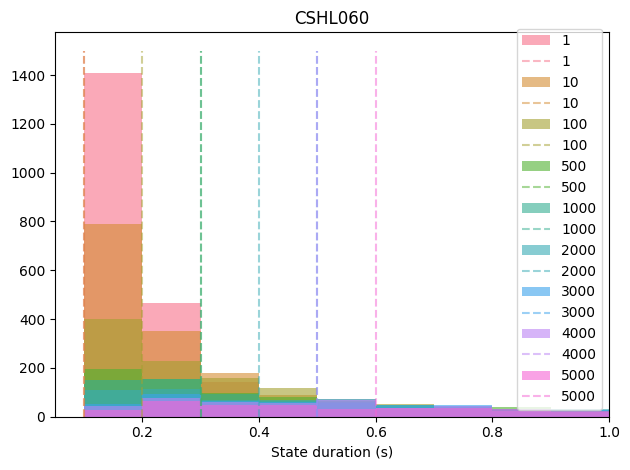

In [41]:

def generate_colors(num_colors):
    # Use seaborn's color_palette to generate a list of colors
    return sns.color_palette('husl', n_colors=num_colors)

# Generate the list of colors
colors = generate_colors(len(np.unique(all_stickinesses)))

# Loop through mice
for m, mouse_name in enumerate(np.unique(mouse_names)[0:2]):
    
    if len(mouse_name) > 0:
        
        # Get mouse data
        mouse_most_likely_states = all_most_likely_states[mouse_name]
        for s, stickiness in enumerate(all_stickinesses):
            stickiness_most_likely_states = mouse_most_likely_states[stickiness]
            
            dif = np.diff(stickiness_most_likely_states)
            jump = np.where(dif != 0)
            jump_dif = np.diff(jump)
            median = np.nanmedian(jump_dif)
            print(median)
            bins = np.arange(0, 20, 1)
            plt.hist(jump_dif[0], bins, alpha=0.6, label=stickiness, color=colors[s])
            plt.vlines(median, 0, 1500, linestyles='--', alpha=0.5, label=stickiness, color=colors[s])
            plt.xticks(np.arange(0, np.max(jump_dif[0]), 2), np.arange(0, np.max(jump_dif[0]), 2)/10)

        plt.legend()
        plt.title(mouse_name)
        plt.xlim([0.5, 10])
        plt.xlabel('State duration (s)')
        plt.tight_layout()
        plt.show()


In [ ]:
def best_params(all_lls, all_baseline_lls, mouse_names, session_all, matrix_all, num_train_batches, Lags):

    lls_lag_state = defaultdict(list)
    
    # Loop through mice
    for m, mouse_name in enumerate(np.unique(mouse_names)):
        # mouse_name = 'DY_013'
        if len(mouse_name) > 0:

            # Initialize mouse data
            lls_lag_state[mouse_name] = {}
            
            # Get mouse data
            session_trials = session_all[mouse_name]
            design_matrix = matrix_all[mouse_name]
            
            if len(np.shape(design_matrix)) > 2:
                design_matrix = design_matrix[0]
                session_trials = session_trials[0]
                
            # Prepare data for cross-validation
            num_timesteps = np.shape(design_matrix)[0]
            shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])

            # Split data into folds
            fold_len =  len(shortened_array)/num_train_batches
            
            for l, lag in enumerate(Lags):
                
                avg_val_lls = all_lls[mouse_name][lag]
                baseline_lls = all_baseline_lls[mouse_name][lag]
                bits_LL = (np.array(avg_val_lls) - np.array(baseline_lls)) / fold_len * np.log(2)
                
                if l == 0:
                    lls_lag_state[mouse_name] = np.nanmean(bits_LL, axis=1)
                else:
                    lls_lag_state[mouse_name] = np.vstack((lls_lag_state[mouse_name], np.nanmean(bits_LL, axis=1)))
        
    # Find best params per mouse
    best_lag = np.arange(0, len(np.unique(mouse_names)), 1) * np.nan
    best_state = np.arange(0, len(np.unique(mouse_names)), 1) * np.nan
    # Loop through mice
    for m, mouse_name in enumerate(np.unique(mouse_names)):
        # mouse_name = 'DY_013'
        try:
            best_lag[m] = Lags[np.where(lls_lag_state[mouse_name]==np.nanmax(lls_lag_state[mouse_name]))[0][0]]
            best_state[m] = States[np.where(lls_lag_state[mouse_name]==np.nanmax(lls_lag_state[mouse_name]))[1][0]]
        except:
            print(mouse_name)
            
    return best_lag, best_state, lls_lag_state


def generate_colors(num_colors):
    # Use seaborn's color_palette to generate a list of colors
    return sns.color_palette('husl', n_colors=num_colors)

### Plot grid with LL

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)



NYU-40
PL017


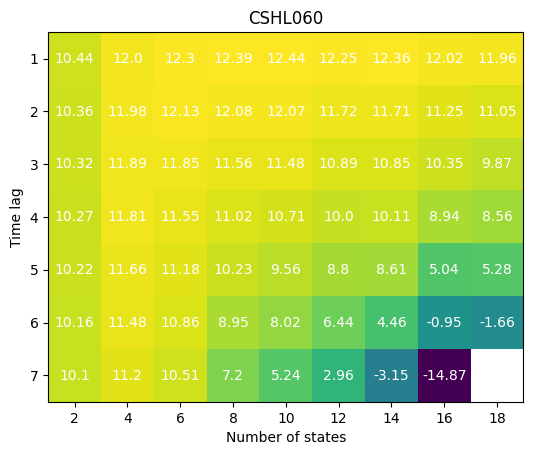

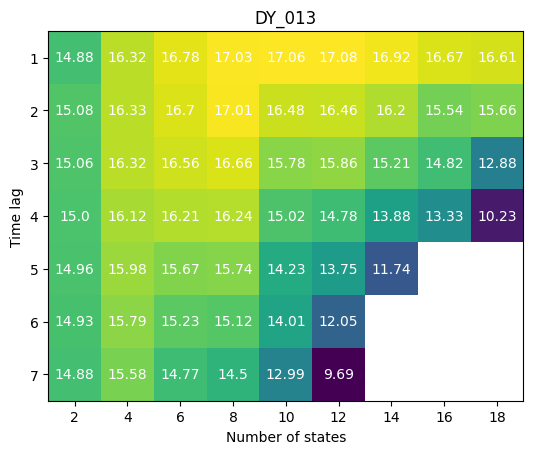

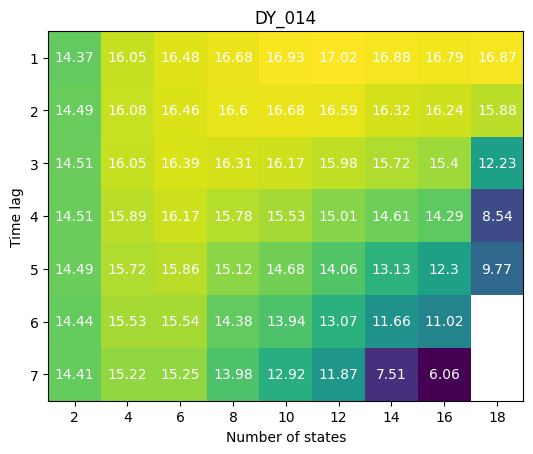

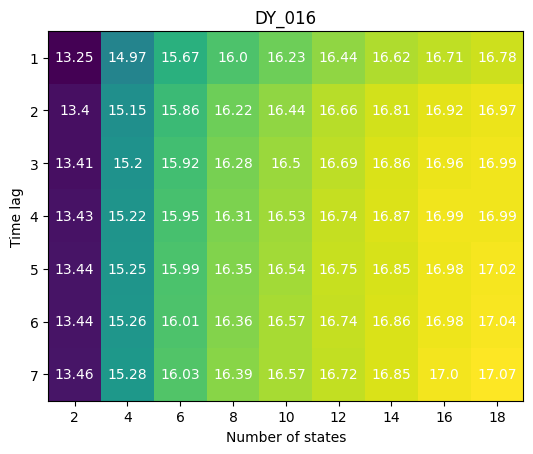

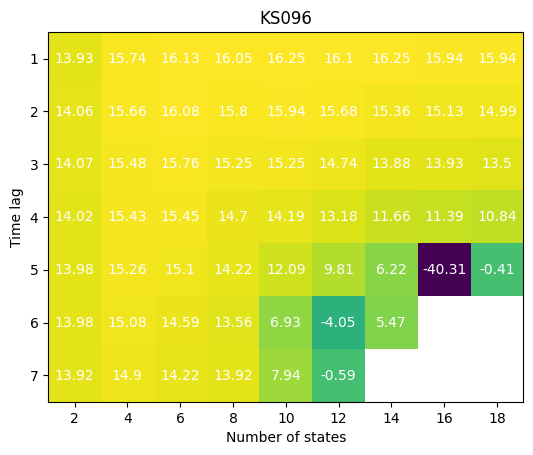

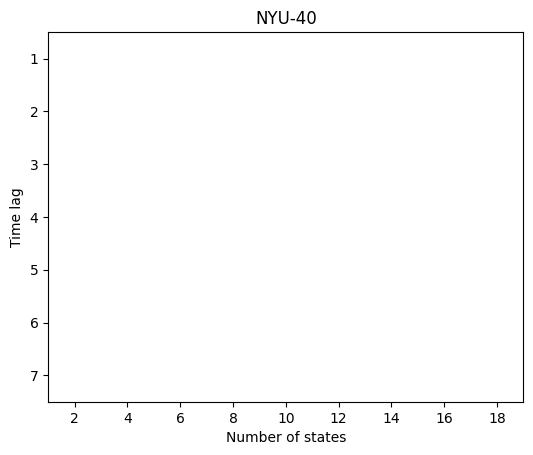

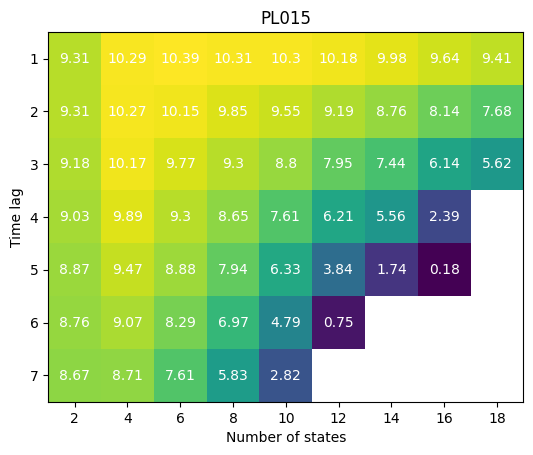

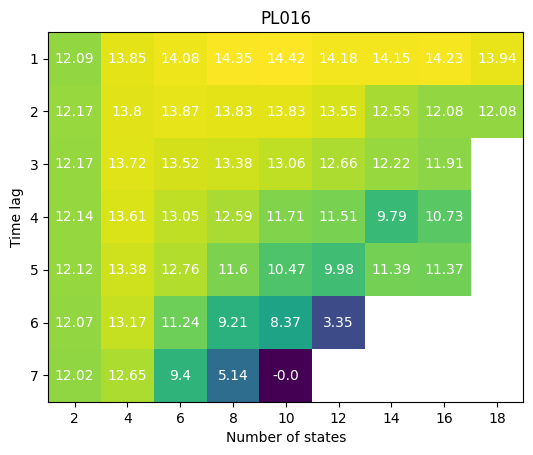

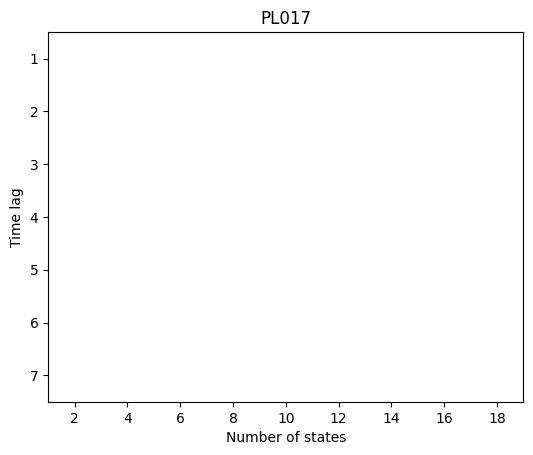

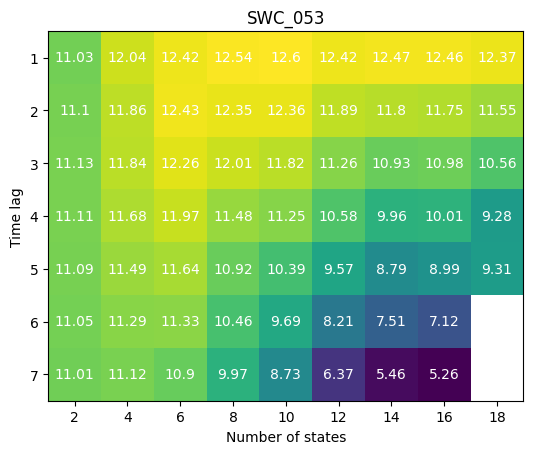

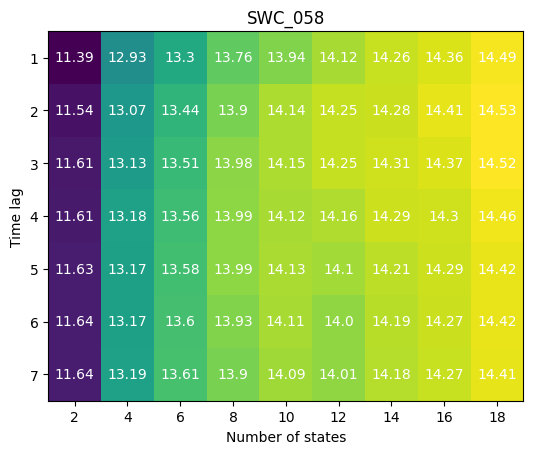

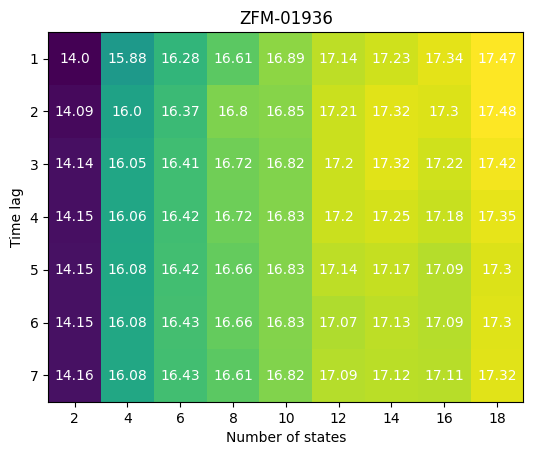

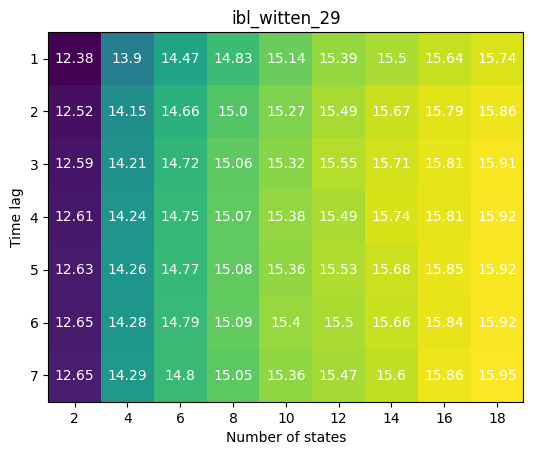

In [14]:
States = list(range(start_step, last_state, state_step))
Lags = list(range(start_lag, last_lag, lag_step))

_, _, lls_lag_state = best_params(all_lls, all_baseline_lls, mouse_names, session_all, matrix_all, num_train_batches, Lags)

# Loop through mice
for m, mouse_name in enumerate(np.unique(mouse_names)):
    # mouse_name = 'DY_013'
    if len(mouse_name) > 0:

        fig, ax = plt.subplots()
        im = ax.imshow(lls_lag_state[mouse_name])

        # Show all ticks and label them with the respective list entries
        ax.set_yticks(np.arange(len(Lags)), labels=Lags)
        ax.set_xticks(np.arange(len(States)), labels=States)
        plt.xlabel('Number of states')
        plt.ylabel('Time lag')
        plt.title(mouse_name)
        # Loop over data dimensions and create text annotations.
        for i in range(len(Lags)):
            for j in range(len(States)):
                text = ax.text(j, i, np.round(lls_lag_state[mouse_name][i, j], decimals=2),
                            ha="center", va="center", color="w")


### Plot scatterplot for best params


NYU-40
PL017


Text(0, 0.5, 'Time lag')

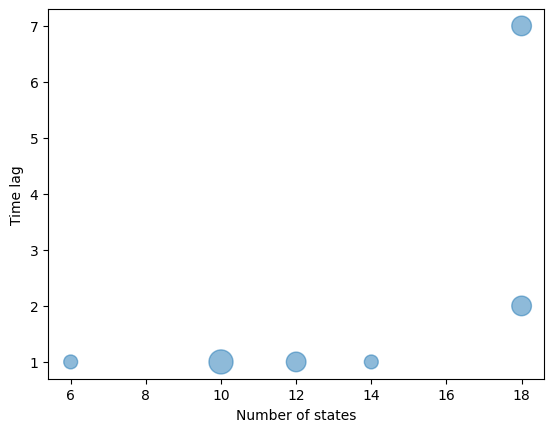

In [15]:
best_lag, best_state, _ = best_params(all_lls, all_baseline_lls, mouse_names, session_all, matrix_all, num_train_batches, Lags)

data = {'States': best_state, 'Lags': best_lag}
df = pd.DataFrame(data)

# Group by X and Y values and count the number of occurrences
grouped_data = df.groupby(['States', 'Lags']).size().reset_index(name='count')

# Scatter plot with marker size based on the count
plt.scatter(grouped_data['States'], grouped_data['Lags'], s=grouped_data['count']*100, alpha=0.5)
plt.xlabel('Number of states')
plt.ylabel('Time lag')


In [38]:
save_data = defaultdict(list)
save_data['mouse_names'] = []
save_data['mouse_names'] = np.unique(mouse_names)
save_data['best_lag'] = []
save_data['best_lag'] = best_lag
save_data['best_state'] = []
save_data['best_state'] = best_state

In [42]:
pickle_file = open('best_results', 'wb')
pickle.dump(save_data, pickle_file)

In [41]:
save_data

defaultdict(list,
            {'mouse_names': array(['', 'CSHL060', 'DY_013', 'DY_014', 'DY_016', 'KS096', 'NYU-40',
                    'PL015', 'PL016', 'PL017', 'SWC_053', 'SWC_058', 'ZFM-01936',
                    'ibl_witten_29'], dtype='<U13'),
             'best_lag': array([nan,  1.,  1.,  1.,  7.,  1., nan,  1.,  1., nan,  1.,  2.,  2.,
                     7.]),
             'best_state': array([nan, 10., 12., 12., 18., 14., nan,  6., 10., nan, 10., 18., 18.,
                    18.])})